In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import cv2
import pygame



pygame 2.2.0 (SDL 2.30.10, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def show_video_from_frames_pygame(frames, fps=30):
    """
    Displays video frames using PyGame, overlays frame IDs, and maintains specified FPS.
    
    Args:
        frames (list): List of video frames (BGR format).
        fps (int): Frames per second for playback.
    
    Returns:
        bool: True if the video plays without interruption; False if 'q' is pressed to quit.
    """
    # Initialize PyGame
    
    if isinstance(frames[0], tuple):
        frame_times = [frame[1] for frame in frames]
        frames = [frame[0] for frame in frames]
    
    pygame.init()
    clock = pygame.time.Clock()

    # Set up the display window
    frame_height, frame_width = frames[0].shape[:2]
    #print(frame_height, frame_width)
    screen = pygame.display.set_mode((frame_width, frame_height))
    pygame.display.set_caption("Video Playback")

    running = True
    for frame_id, frame in enumerate(frames):
        
        # Handle events (exit on quit or 'q' key)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN and event.key == pygame.K_q:
                running = False
        
        if not running:
            break

        # Convert the frame from BGR (OpenCV format) to RGB (PyGame format)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Overlay the frame ID on the frame
        text = f"Frame: {frame_id}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (200, 30)
        font_scale = 1
        font_color = (255, 255, 255)  # White
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(frame, text, position, font, font_scale, font_color, thickness, line_type)

        # Convert frame to a surface for PyGame
        frame_surface = pygame.surfarray.make_surface(np.transpose(frame, (1,0,2)))

        # Display the frame on the PyGame window
        screen.blit(frame_surface, (0, 0))
        pygame.display.flip()

        # Wait to maintain the desired FPS
        clock.tick(fps)

    # Quit PyGame
    pygame.quit()
    return running

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

def load_frames_by_time_range(video_file, start_timestamp, end_timestamp, offset=0, delay_frames=0):
    cap = cv2.VideoCapture(video_file)
    frames = []
    
    timestamps_file = video_file.replace(".avi", "_timestamps.txt")
    start_time, end_time = None, None
    for line in open(timestamps_file, "r").readlines():
        if line.startswith("Recording Start Time:"):
            start_time = float(line.split(":")[-1])
        if line.startswith("Recording End Time:"):
            end_time = float(line.split(":")[-1])
    
    assert start_time is not None and end_time is not None, "Could not read start and end time from file"
    
    # Get video FPS and total number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate delay time and adjust start and end timestamps
    delay_time = delay_frames * 1 / fps  # Delay in seconds
    start_time += delay_time
    end_time += delay_time

    # Calculate the start and end frame indices
    start_frame = int((start_timestamp - start_time) * fps) + offset
    end_frame = int((end_timestamp - start_time) * fps) + offset

    # Ensure the frame indices are within bounds
    start_frame = max(0, start_frame)
    end_frame = min(total_frames, end_frame)

    # Seek to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames sequentially
    for frame_index in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break  # Stop if we can't read the frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_time = start_time + frame_index / fps
        frames.append((frame, frame_time))
    
    cap.release()
    return frames

from scipy.spatial.transform import Rotation

def normalize_hand_landmarks(landmarks):
    """
    Normalizes the 3D hand landmarks by rotating them such that they are aligned.
    
    Parameters:
        landmarks (numpy array): Array of shape (N, 3), where N is the number of landmarks.
    
    Returns:
        normalized_landmarks (numpy array): The normalized landmarks.
    """
    assert landmarks.ndim == 2
    # 1. Compute the centroid (center) of the hand
    centroid = np.mean(landmarks, axis=0)
    
    # 2. Translate landmarks so the centroid is at the origin
    translated_landmarks = landmarks - centroid
    
    # 3. Define key points to compute orientation (e.g., wrist and middle finger)
    # Assume landmarks[0] is wrist, and landmarks[9] is the tip of the middle finger.
    wrist = translated_landmarks[0,:]
    middle_finger_tip = translated_landmarks[9,:]
    
    # 4. Compute the vector representing the orientation (e.g., wrist to middle finger tip)
    orientation_vector = middle_finger_tip - wrist
    
    # 5. Normalize the orientation vector to unit length
    orientation_vector /= np.linalg.norm(orientation_vector)
    
    # 6. Define the target orientation (e.g., along the Z-axis)
    target_orientation = np.array([0, 0, 1])
    
    # 7. Compute the rotation matrix that aligns the orientation vector with the target orientation
    axis_of_rotation = np.cross(orientation_vector, target_orientation)
    angle_of_rotation = np.arccos(np.dot(orientation_vector, target_orientation))
    
    if np.linalg.norm(axis_of_rotation) > 1e-6:  # If there's a non-zero rotation axis
        rotation = Rotation.from_rotvec(angle_of_rotation * axis_of_rotation)
        rotation_matrix = rotation.as_matrix()
        
        # 8. Apply the rotation matrix to all landmarks
        normalized_landmarks = np.dot(translated_landmarks, rotation_matrix.T)
    else:
        normalized_landmarks = translated_landmarks  # No rotation needed if already aligned
    
    return normalized_landmarks


def normalize_sequence_with_consistent_rotation(landmark_sequence):
    """
    Normalizes a sequence of 3D hand landmarks by aligning all frames using a consistent rotation.
    
    Parameters:
        landmark_sequence (numpy array): Array of shape (T, N, 3), where T is the number of frames, 
                                          N is the number of landmarks, and 3 corresponds to the (x, y, z) coordinates.
    
    Returns:
        normalized_sequence (numpy array): The normalized landmarks for the entire sequence.
    """
    assert landmark_sequence.ndim == 3, "Input must be a 3D array of shape (T, N, 3)"
    
    # Use the first frame as the reference for computing the rotation
    reference_frame = landmark_sequence[0]
    
    # Compute the centroid of the reference frame
    reference_centroid = np.mean(reference_frame, axis=0)
    
    # Translate the reference frame so its centroid is at the origin
    reference_translated = reference_frame - reference_centroid
    
    # Define key points in the reference frame
    wrist = reference_translated[0]  # Assume the first landmark is the wrist
    middle_finger_tip = reference_translated[9]  # Assume the 10th landmark is the middle finger tip
    
    # Compute the orientation vector in the reference frame
    orientation_vector = middle_finger_tip - wrist
    orientation_vector /= np.linalg.norm(orientation_vector)  # Normalize to unit length
    
    # Define the target orientation (e.g., along the Z-axis)
    target_orientation = np.array([0, 0, 1])
    
    # Compute the rotation matrix to align the reference orientation with the target orientation
    axis_of_rotation = np.cross(orientation_vector, target_orientation)
    angle_of_rotation = np.arccos(np.dot(orientation_vector, target_orientation))
    
    if np.linalg.norm(axis_of_rotation) > 1e-6:  # Non-zero rotation
        rotation = Rotation.from_rotvec(angle_of_rotation * axis_of_rotation)
        rotation_matrix = rotation.as_matrix()
    else:
        rotation_matrix = np.eye(3)  # Identity matrix if no rotation is needed
    
    # Apply the computed rotation matrix to all frames
    normalized_sequence = []
    for frame in landmark_sequence:
        # Translate the current frame to the origin
        translated_frame = frame - np.mean(frame, axis=0)
        # Apply the same rotation matrix
        normalized_frame = np.dot(translated_frame, rotation_matrix.T)
        normalized_sequence.append(normalized_frame)
    
    return np.array(normalized_sequence)




label_file = r"C:\Users\lhauptmann\Code\WristPPG2\data\labels\label_228.csv"
video_file = r"C:\Users\lhauptmann\Code\WristPPG2\data\webcam_recordings\webcam_228.avi"

label_df = pd.read_csv(label_file)
single_gesture = label_df[label_df["label"] == "a"].iloc[5]
start_time = label_df["start_time"].iloc[0]
end_time = label_df[~label_df["label"].isin(["o", "s"])]["end_time"].iloc[-1]

In [52]:

def annotate_video(frames):
    BaseOptions = mp.tasks.BaseOptions
    HandLandmarker = mp.tasks.vision.HandLandmarker
    HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode
    

    # Create a hand landmarker instance with the video mode:
    options = HandLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=r'C:\Users\lhauptmann\Code\WristPPG2\hand_landmarker.task'),
        running_mode=VisionRunningMode.VIDEO,
        num_hands=2,
        min_hand_detection_confidence = 0.3,
        min_hand_presence_confidence = 0.3,
        min_tracking_confidence = 0.3
        )

    results = []
    annotated_frames = []
    with HandLandmarker.create_from_options(options) as landmarker:
        

        for fr, frame_time in frames:
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=fr)

            result = landmarker.detect_for_video(mp_image, timestamp_ms=int(frame_time*1000))
            results.append(result)
            annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), result)
            annotated_frames.append(annotated_image)
    return results, annotated_frames

frames = load_frames_by_time_range(video_file, start_time, end_time, offset = 0, delay_frames = 0)
annotations, annotated_frames = annotate_video(frames)


In [53]:
show_video_from_frames_pygame(annotated_frames, fps=30)

KeyboardInterrupt: 

In [54]:
selected_labels = label_df[~label_df["label"].isin(["s", "pbd", "prr", "prl", "po"])]
label_times = np.array([el[1] for el in frames])


gesture_landmarks = []

for index, row in selected_labels.iterrows():
    
    label_start_time, label_end_time = row["start_time"], row["end_time"]
    label_indices = np.searchsorted(label_times, [label_start_time, label_end_time])
    #label_frames = annotated_frames[label_indices[0]:label_indices[1]]
    label_landmarks = annotations[label_indices[0]:label_indices[1]]
    """
    for frame in label_frames:
        cv2.imshow("frame", frame)
        if cv2.waitKey(50) & 0xFF == ord('q'):  # Press 'q' to exit
            break
    
    cv2.destroyAllWindows()
    """
    
    
    def extract_landmarks_xyz(label_landmarks, hand_index = 0):
        
        landmarks = []
        
        for hand_landmarks in label_landmarks:
            hand_index = None
            for i, hand in enumerate(hand_landmarks.handedness):
                if hand[0].category_name == "Right":
                    hand_index = i
                
            if hand_index is None:
                continue
            
            landmark_coordinates = np.array([[landmark.x, landmark.y, landmark.z] for landmark in hand_landmarks.hand_world_landmarks[hand_index]])
            
            landmarks.append(landmark_coordinates)
            
        return np.atleast_3d(np.array(landmarks))
                
    
    gesture_landmark = extract_landmarks_xyz(label_landmarks)
    if gesture_landmark.shape[0] > 1:
        gesture_landmark = normalize_sequence_with_consistent_rotation(gesture_landmark)
        gesture_landmark = gesture_landmark[:,:8,:] # select only certain landmarks (thumb, index)
        gesture_landmark =  gesture_landmark.reshape(gesture_landmark.shape[0], -1)
        
    gesture_landmarks.append(gesture_landmark)
    
    
gesture_handmarks_mask = np.array([el.shape[0] for el in gesture_landmarks]) > 1
    
gesture_landmarks = [el for el, mask in zip(gesture_landmarks, gesture_handmarks_mask) if mask]

In [55]:
from dtaidistance import dtw_ndim

def compute_dtw_matrix(sequences):
    """
    Compute pairwise DTW distances for a set of sequences.
    """
    n = len(sequences)
    dtw_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            sequence_1, sequence_2 = sequences[i], sequences[j]
            if sequence_1.shape[0] <= 1 or  sequence_2.shape[0] <= 1:
                distance = np.inf  # Skip sequences with different lengths
            else:
                distance = dtw_ndim.distance(sequences[i], sequences[j])
            dtw_matrix[i, j] = distance
            dtw_matrix[j, i] = distance  # Symmetric matrix
    return dtw_matrix



dtw_distances = compute_dtw_matrix(gesture_landmarks)


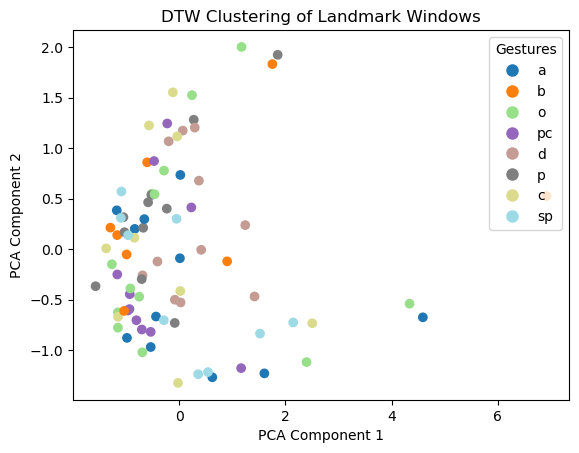

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Prepare gesture labels and indices
selected_gestures = selected_labels["label"][gesture_handmarks_mask].tolist()
selected_labels_dict = {label: index for index, label in enumerate(set(selected_gestures))}
selected_labels_indices = [selected_labels_dict[label] for label in selected_gestures]

# Step 4: Visualize results
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(dtw_distances)

# Create scatter plot
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=selected_labels_indices, cmap='tab20')

# Create a legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=scatter.cmap(scatter.norm(index)), markersize=10)
    for label, index in selected_labels_dict.items()
]
plt.legend(handles=legend_elements, title="Gestures", loc='upper right')

plt.title("DTW Clustering of Landmark Windows")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
#plt.xlim(-100, 100)
#plt.ylim(-2,2)
plt.show()



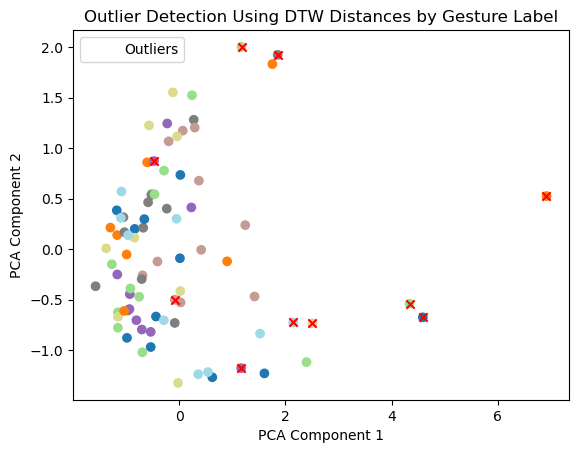

Outliers for label 'a': [8]
Outliers for label 'b': [3]
Outliers for label 'o': [13, 29]
Outliers for label 'pc': [7, 71]
Outliers for label 'd': [45]
Outliers for label 'p': [36]
Outliers for label 'c': [55]
Outliers for label 'sp': [9]


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Assuming you have your dtw_distances matrix (n x n) and selected_labels with labels for each sample

# Step 1: Group points by their labels
labels = selected_labels["label"][gesture_handmarks_mask].tolist()
unique_labels = set(labels)

# Step 2: Prepare a dictionary to store outliers for each label
outliers_by_label = {label: [] for label in unique_labels}

# Step 3: Iterate through each label and perform outlier detection

for label in unique_labels:
    # Get indices of points belonging to the current label
    label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
    
    # Extract the DTW distances for points belonging to the current label
    label_dtw_distances = dtw_distances[label_indices, :][:, label_indices]  # n x n matrix for this label
    
    # Step 4: Calculate the average DTW distance for each point within the label
    average_dtw_distances = np.mean(label_dtw_distances, axis=1)  # Average distance to all other points in the label
    
    # Step 5: Calculate the mean and std of the average DTW distances
    mean_distance = np.mean(average_dtw_distances)
    std_distance = np.std(average_dtw_distances)
    
    # Step 6: Define a threshold for outliers (e.g., 2 std above the mean)
    outlier_threshold = mean_distance +1.2 * std_distance
    
    # Step 7: Identify outliers within this label
    outliers_in_label = [i for i, dist in zip(label_indices, average_dtw_distances) if dist > outlier_threshold]
    
    # Store the outliers for this label
    outliers_by_label[label] = outliers_in_label

# Step 8: Visualize the results using PCA (for dimensionality reduction)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(dtw_distances)  # Use DTW distance matrix for dimensionality reduction

# Step 9: Plot the results
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=[selected_labels_dict[label] for label in labels], cmap='tab20')

# Highlight outliers in red for each label
for label, outliers in outliers_by_label.items():
    label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
    outlier_points = reduced_features[outliers]
    
    # Plot outliers in red
    plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red', label=f'Outliers for {label}', marker='x')

# Create a legend for gestures
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=scatter.cmap(scatter.norm(selected_labels_dict[label])), markersize=10)
    for label in unique_labels
]
plt.legend(handles=legend_elements, title="Gestures", loc='upper right')

# Create a legend for outliers
plt.legend(handles=[Line2D([0], [0], marker='x', color='w', label='Outliers', markerfacecolor='red', markersize=10)], loc='upper left')

plt.title("Outlier Detection Using DTW Distances by Gesture Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Optionally, print outliers for each label
for label, outliers in outliers_by_label.items():
    print(f"Outliers for label '{label}': {outliers}")


In [67]:
all_outliers = np.array([item for sublist in outliers_by_label.values() for item in sublist])

In [68]:
selected_labels[gesture_handmarks_mask].iloc[all_outliers]

,start_time,end_time,label
13,1.733297e+09,1.733297e+09,a
4,1.733297e+09,1.733297e+09,b
19,1.733297e+09,1.733297e+09,o
56,1.733297e+09,1.733297e+09,o
9,1.733297e+09,1.733297e+09,pc
130,1.733297e+09,1.733297e+09,pc
97,1.733297e+09,1.733297e+09,d
70,1.733297e+09,1.733297e+09,p
109,1.733297e+09,1.733297e+09,c
14,1.733297e+09,1.733297e+09,sp


In [69]:
for outliere_index in all_outliers:
    outlier = selected_labels[gesture_handmarks_mask].iloc[outliere_index]
    outlier_video = load_frames_by_time_range(video_file, outlier["start_time"], outlier["end_time"], offset = 0, delay_frames = 0)

    show_video_from_frames_pygame(outlier_video, fps=10)

In [13]:
landmarks_ex = np.array([np.array((el.x, el.y, el.z)) for el in annotations[100].hand_world_landmarks[0]])

normalized_landsmarks_ex = normalize_hand_landmarks(landmarks_ex)

In [61]:
import numpy as np
import plotly.graph_objects as go

def plot_3d_landmarks(landmarks, connections=None, title="3D Hand Landmarks"):
    """
    Creates an interactive 3D plot of hand landmarks using Plotly.
    
    Parameters:
        landmarks (np.ndarray): Array of shape (N, 3), where N is the number of landmarks.
        connections (list of tuple, optional): List of tuples representing connections between points.
        title (str): Title of the plot.
    """
    # Extract X, Y, Z coordinates
    x, y, z = landmarks[:, 0], landmarks[:, 1], landmarks[:, 2]

    # Create scatter trace for the landmarks
    scatter_trace = go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8),
        name='Landmarks'
    )

    # Create line traces for connections (if provided)
    line_traces = []
    if connections:
        for start, end in connections:
            line_traces.append(
                go.Scatter3d(
                    x=[x[start], x[end]],
                    y=[y[start], y[end]],
                    z=[z[start], z[end]],
                    mode='lines',
                    line=dict(color='red', width=2),
                    name=f'Connection {start}-{end}',
                )
            )

    # Combine traces
    traces = [scatter_trace] + line_traces

    # Create layout
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X-axis'),
            yaxis=dict(title='Y-axis'),
            zaxis=dict(title='Z-axis'),
        ),
    )

    # Create figure and plot
    fig = go.Figure(data=traces, layout=layout)
    fig.show()


# Define connections between points (optional)
connections = [
    (0, 1),  # Connection from point 0 to point 1
    (1, 2),  # Connection from point 1 to point 2
    (2, 3),  # Connection from point 2 to point 3
    (2, 3),
    (3, 4),
    (0, 5),
    (5, 6),
    (6, 7),
    (7, 8),
    (0, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (0, 13),
    (13, 14),
    (14, 15),
    (15, 16),
    (0, 17),
    (17, 18),
    (18, 19),
    (19, 20),
    (5, 9),
    (9, 13),
    (13, 17),
]

    
plot_3d_landmarks(normalized_landsmarks_ex, connections=connections)
        

NameError: name 'normalized_landsmarks_ex' is not defined

In [31]:
plot_3d_landmarks(gesture_landmarks[0].reshape(36, -1, 3), connections=connections)

In [28]:
gesture_landmarks[0].reshape(36, -1, 3).shape

(36, 8, 3)